In [1]:
from densitysplit.pipeline import DensitySplit
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_format='retina'
%matplotlib inline
rc('text', usetex=True)

data_dir = './data'
data_fn = Path(data_dir, 'mock_data.fits')

with fits.open(data_fn) as hdul:
    data = hdul[1].data
data_positions = np.c_[data['X'], data['Y'], data['Z']]

In [2]:
%%time
boxsize = 1500
smooth_radius = 20
nmesh = 128
cellsize = 10.0

ds = DensitySplit(data_positions=data_positions, boxsize=boxsize)

density = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling='randoms')

CPU times: user 1.79 s, sys: 140 ms, total: 1.93 s
Wall time: 1.93 s


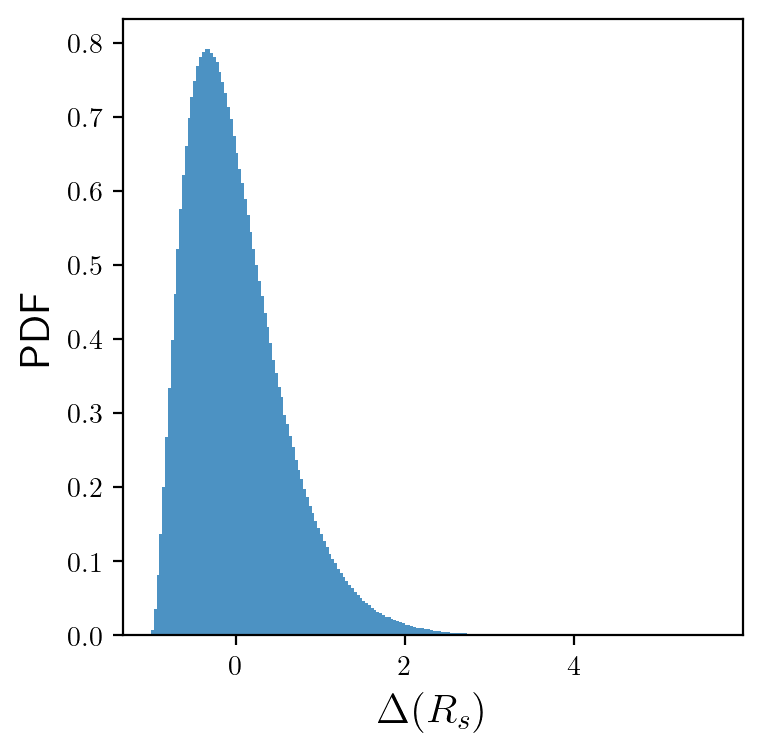

In [3]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(density, bins=200, density=True, alpha=0.8)
ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
plt.show()

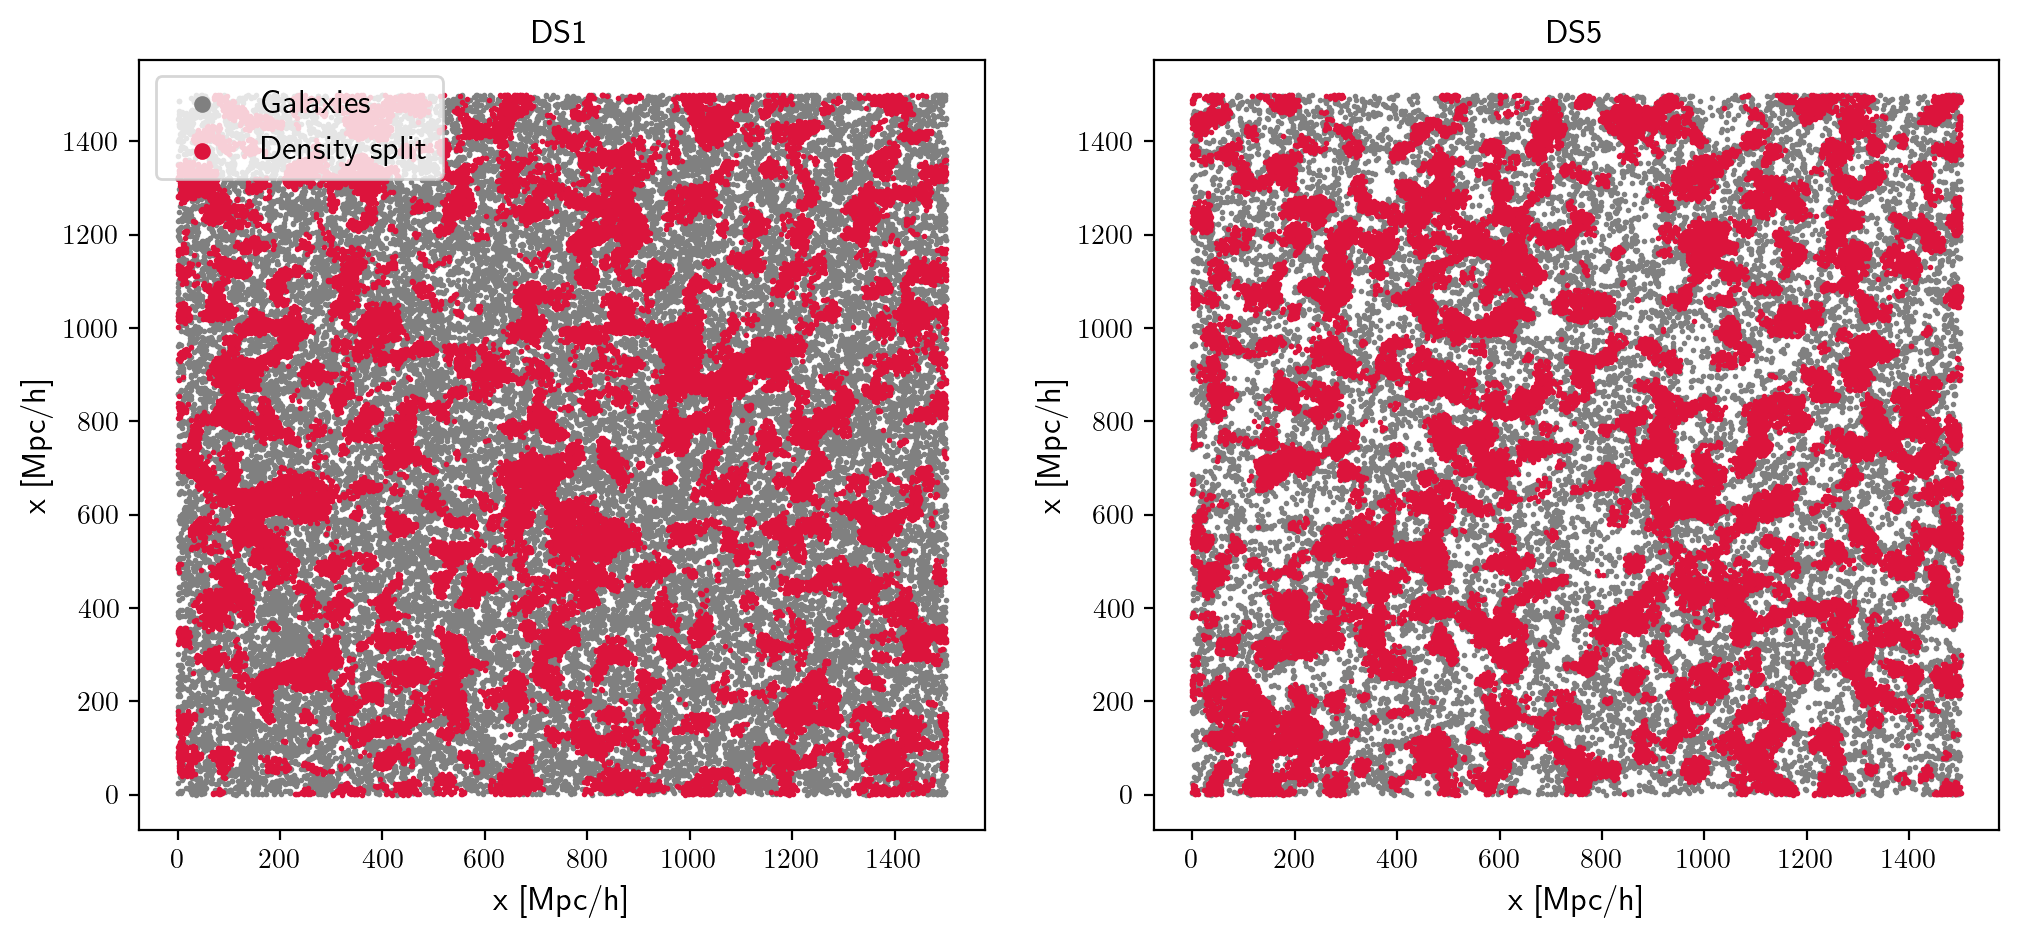

In [4]:
quantiles = ds.get_quantiles(nquantiles=5)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cut = data_positions[:, 2] < 50
ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=1.0, color='grey', label='Galaxies')
ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=1.0, color='grey', label='Galaxies')

for i, ids in enumerate([0, 4]):
    cut = quantiles[ids][:, 2] < 50

    ax[i].scatter(quantiles[ids][cut, 0], quantiles[ids][cut, 1],
        s=1.0, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids + 1}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
    
#     ax[i].set_xlim(0, boxsize)
#     ax[i].set_ylim(0, boxsize)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show()

In [5]:
%%time

randoms_positions = np.random.uniform(0, boxsize, (10*len(data_positions), 3))
sampling_positions = np.random.uniform(0, boxsize, (10*len(data_positions), 3))

ds = DensitySplit(data_positions=data_positions, randoms_positions=randoms_positions)

density_wrand = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize,
    sampling='randoms', sampling_positions=sampling_positions)

CPU times: user 12.4 s, sys: 955 ms, total: 13.3 s
Wall time: 13.6 s


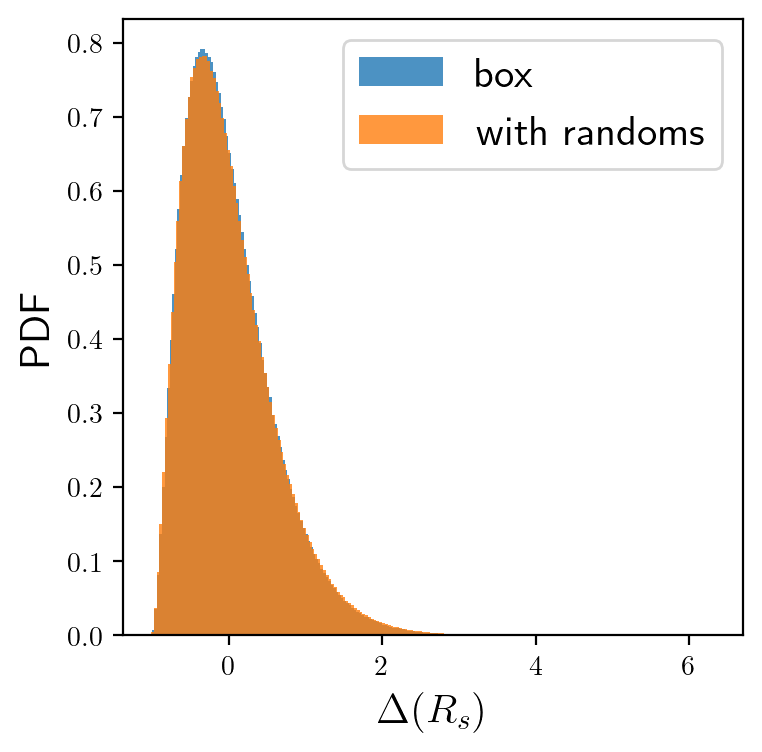

66787550
13357510
13357510
0.0
13357510
[226 226 226]


In [6]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(density, bins=200, density=True, alpha=0.8, label='box')
ax.hist(density_wrand, bins=200, density=True, alpha=0.8, label='with randoms')
ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.legend(fontsize=15)
plt.show()

print(len(data_positions)*50)
print(len(randoms_positions))
print(len(density_wrand))
print(np.sum(np.isnan(density_wrand))/ np.sum(~np.isnan(density_wrand)))
print(np.sum(~np.isnan(density_wrand)))
print(ds.mesh.nmesh)

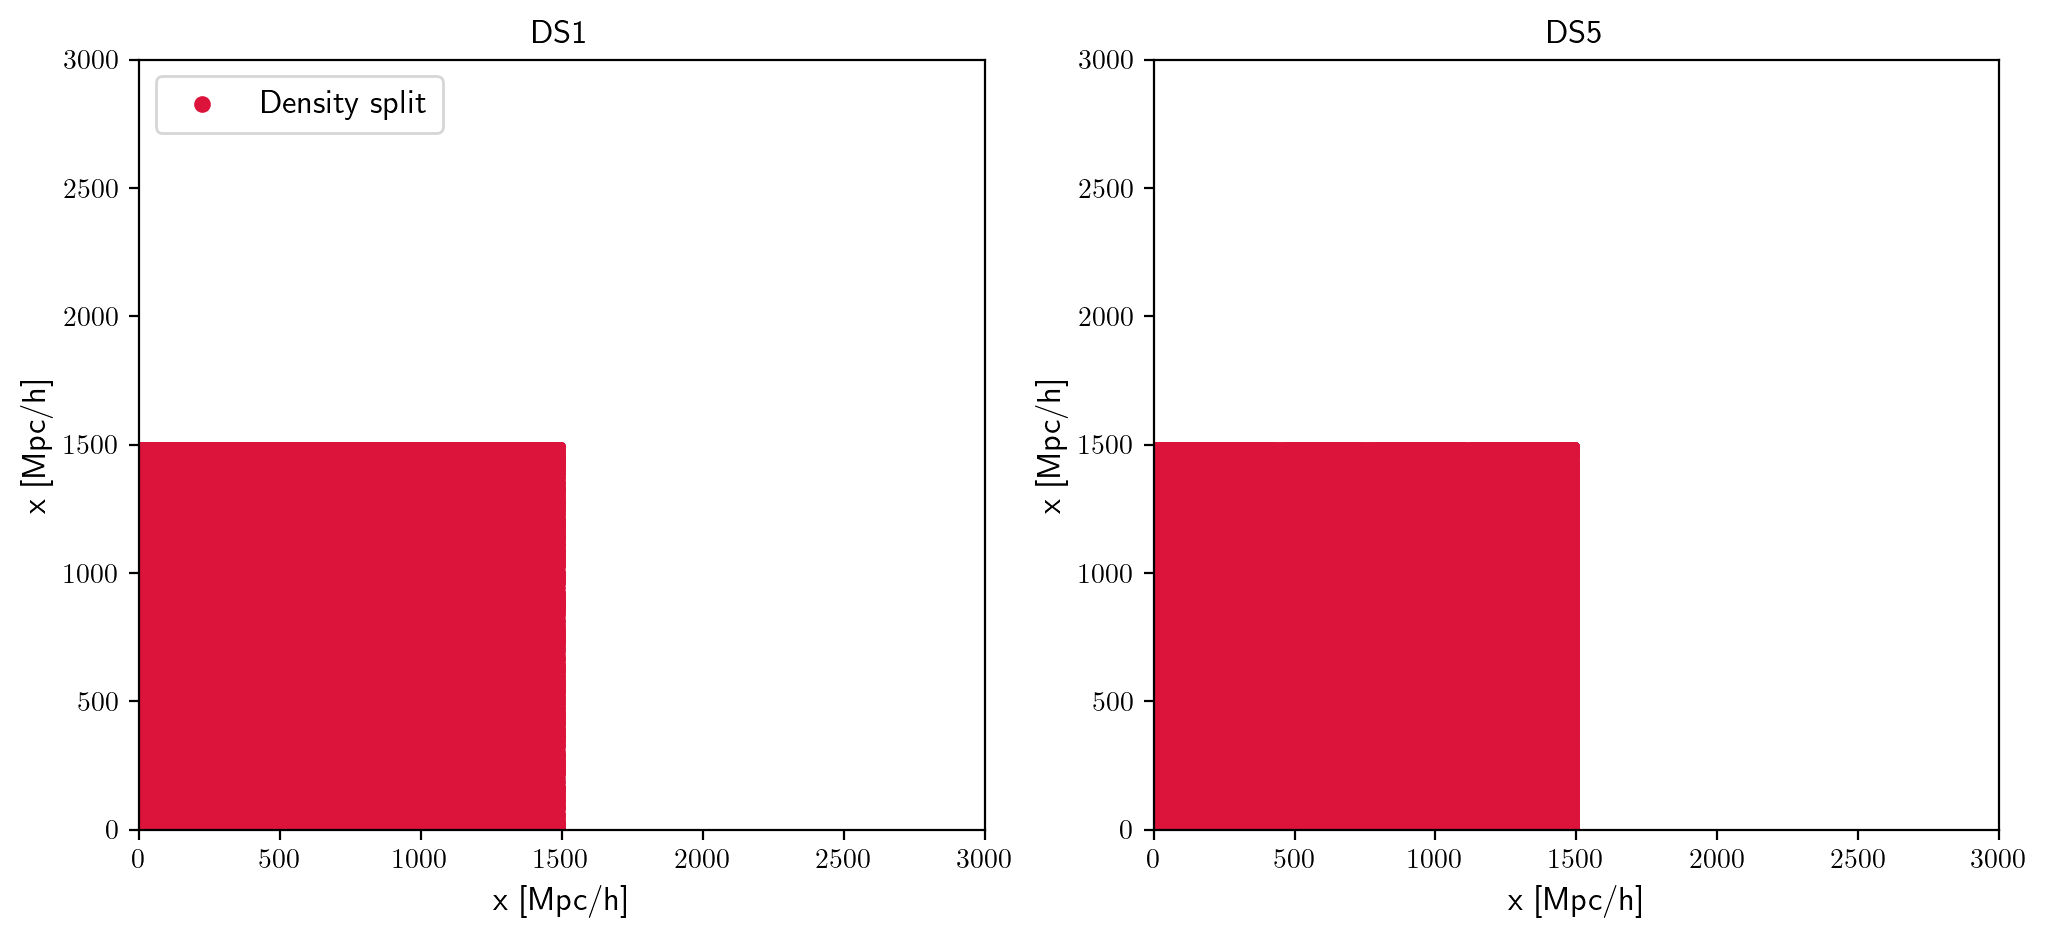

[749.99998613 749.99994192 750.00006148]
[2260. 2260. 2260.]


In [7]:
quantiles = ds.get_quantiles(nquantiles=5)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# cut = data_positions[:, 2] < 50
# ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=1.0, color='grey', label='Galaxies')
# ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=1.0, color='grey', label='Galaxies')

for i, ids in enumerate([0, 4]):
    cut = quantiles[ids][:, 2] < 1500

    ax[i].scatter(quantiles[ids][cut, 0], quantiles[ids][cut, 1],
        s=1.0, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids + 1}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
    
    ax[i].set_xlim(0, 3000)
    ax[i].set_ylim(0, 3000)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show()

print(ds.mesh.boxcenter)
print(ds.mesh.boxsize)

In [8]:
# ds = DensitySplit(data_positions=data_positions, boxsize=boxsize)

# density_data = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling='data')
# density_randoms = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling='randoms')

# fig, ax = plt.subplots(figsize=(4,4))
# ax.hist(density_data, bins=200, density=True, alpha=0.8, label='around data')
# ax.hist(density_randoms, bins=200, density=True, alpha=0.8, label='around randoms')
# ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
# ax.set_ylabel('PDF', fontsize=15)
# ax.legend(fontsize=15)
# plt.show()